This notebook contains an implementation of the block SVD algorithm described in [LAWN 283](http://www.netlib.org/lapack/lawnspdf/lawn283.pdf)

## Block and Unblock Arrays

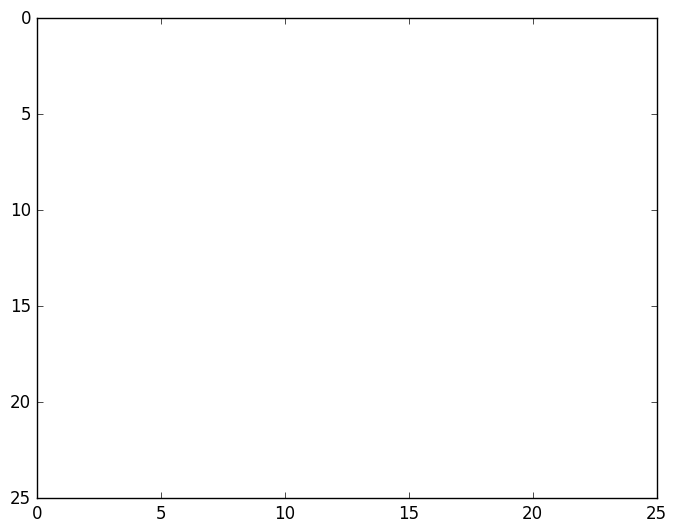

rect_gray (generic function with 2 methods)

In [1]:
################################################################
###### Imports
################################################################

# For Linear Algebra
import Base.LinAlg: QRPackedQ, Ac_mul_B, Ac_mul_Bc!, ctranspose
import Base.*

# For Visualization 
using PyCall
import PyCall: PyObject
import PyPlot
@pyimport matplotlib as matplotlib
@pyimport matplotlib.patches as patches
@pyimport matplotlib.animation as anim

const plt = PyPlot # To prevent function name conflicts (spy)

# Fix path to FFmpeg
matplotlib.rcParams["animation.ffmpeg_path"] = "/usr/local/bin/ffmpeg"


################################################################
###### Function Overrides
################################################################

# JiaHao's Fix
ctranspose(Q::Base.LinAlg.QRCompactWYQ) = full(Q)'

function block(A,s1=5,s2=5)  
    m, n=size(A)
    mi=[i:min(i+s1-1,m) for i=1:s1:m]
    ni=[j:min(j+s2-1,n) for j=1:s2:n]
    [A[i,j] for i in mi, j in ni]
end

unblock(A)=hvcat(tuple([size(A,2) for i=1:size(A,1)]...), A'...) 

# Key BLAS3 block operator
# A few block apply Q's
Ac_mul_B(Q::QRPackedQ,B)=hcat([block(Q'*unblock(B[:,j])) for j in 1:size(B,2)]...)           
*{T<:Matrix}(A::Array{T},Q::QRPackedQ)=vcat([block(unblock(A[i,:])*Q) for i in 1:size(A,1)]...)   
                                        
# A few block qrQ's
qrQ{T<:Number}(A::Array{T})=qrfact(A)[:Q]
qrQ{T<:Matrix}(A::Array{T})=qrQ(unblock(A))  
qrQc{T<:Matrix}(A::Array{T})=qrQ(unblock(A)')
                                 
spyt{T<:Number}(A::Array{T})= plt.spy(A, precision=sqrt(eps(T)), alpha=0.8)  
spy{T<:Matrix}(A::Array{T})= plt.spy(unblock(A), precision=sqrt(eps()), alpha=0.7)  # Threshold for convenience


################################################################
###### Convenience Drawing Functions
################################################################

plt.autoscale(enable=true)
plt.gca()[:set_xlim](0, 25)
plt.gca()[:set_ylim](25, 0)

offset = 1.4

# rect_color(horizontal_offset, vertical_offset, width, height)
rect_red(x0, y0, dx, dy)=  plt.gca()[:add_patch](patches.Rectangle((x0-offset,y0-offset),dx,dy,linewidth=4,facecolor="none",edgecolor= "red"))
rect_blue(x0, y0, dx, dy)= plt.gca()[:add_patch](patches.Rectangle((x0-offset,y0-offset),dx,dy,linewidth=6,facecolor="none",edgecolor= "SlateBlue"))
rect_gray(x0, y0, dx, dy)= plt.gca()[:add_patch](patches.Rectangle((x0-offset,y0-offset),dx,dy,linewidth=2,facecolor="none",edgecolor="#aaaaaa"))

rect_red(yr, xr)=rect_red(start(xr),start(yr),length(xr),length(yr))
rect_blue(yr, xr)=rect_blue(start(xr),start(yr),length(xr),length(yr))
rect_gray(yr, xr)=rect_gray(start(xr),start(yr),length(xr),length(yr))

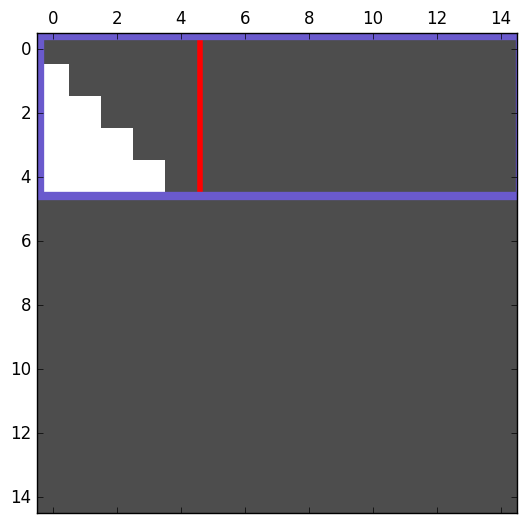

PyObject <matplotlib.patches.Rectangle object at 0x31a00ee50>

In [2]:
N=15
s=5; #block size
A=block(randn(N,N));
Q=qrQ(A[1,1])
A[1]= Q'* A[1]

A[1, [1]] = A[1, [1]]'
spy(A)

rect_red(1:s,1:s)  #QR from this block
rect_blue(1:s,1:N) #QR applied to this block


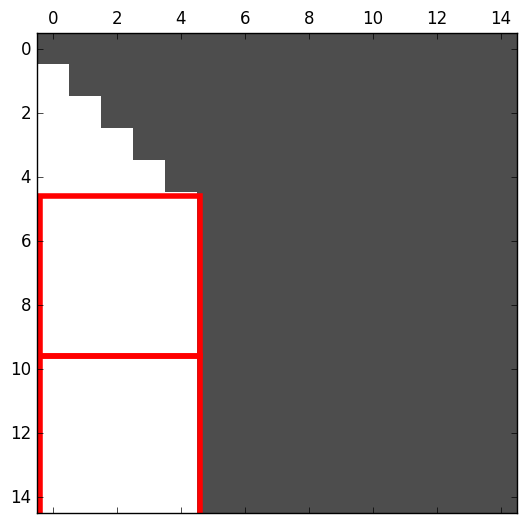

PyObject <matplotlib.image.AxesImage object at 0x31a3d8f50>

In [3]:
for j = 2:3
    
    Q=qrQ(A[[1, j], 1])             # There is a special QR for a "domino"=[◥;◼]
    
     A[[1,j],:] = block(Q' * unblock(A[[1,j],:])) # Q' acts like a square matrix even though Q was "thin" 
    rect_red(1,(j-1)*s+1,s,s)  # QR from this block
end

A[1, [1]] = A[1, [1]]' # Fix for block 1
spy(A)


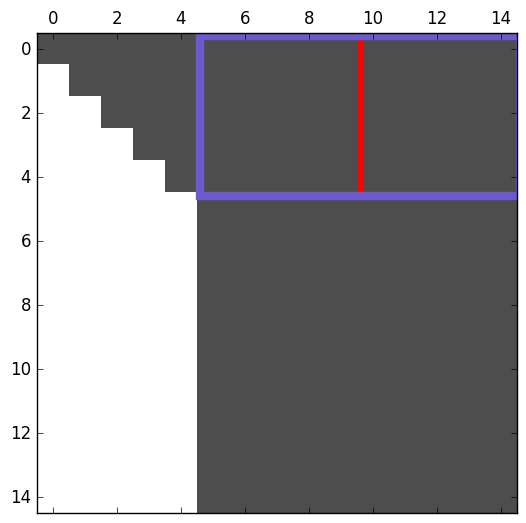

PyObject <matplotlib.patches.Rectangle object at 0x31a6a5550>

In [4]:
#Now do this from the right
Q = qrfact( A[1,2]')[:Q]  # We really need an LQ

A[:, 2] = block(unblock(A[:,2]) * Q)

spy(A)
rect_red(s+1,1,s,s)  #QR from this block
rect_blue(1:s,s+1:N) #QR applied to this block

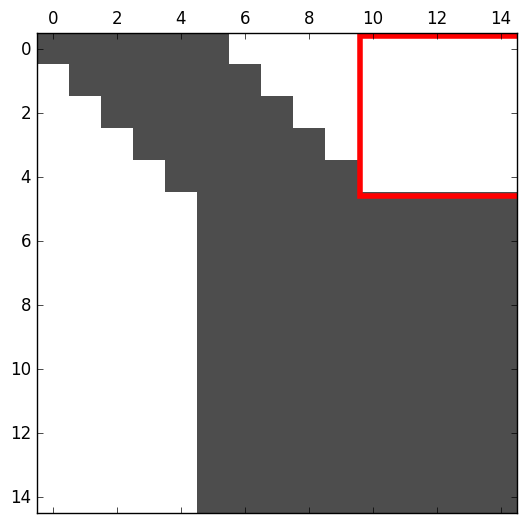

PyObject <matplotlib.image.AxesImage object at 0x31a98b5d0>

In [5]:
for j=3:3
    Q=qrQ(unblock(A[1,[2,j]])') # This is a special LQ for a "domino"=[◥;◼]'  
    A[:,[2,j]] = (block(unblock(A[:,[2,j]]) * Q))

    rect_red((j-1)*s+1,1,s,s)#QR from this block
end

A[1, [2]] = A[1, [2]]'
spy(A)

In [6]:
function BandBidiagonal(A::Array{Array{Float64,2},2}, record_video=false, video_file="band_bidiagonal.mp4") 
    
    # Video Settings
    if record_video
        video = anim.FFMpegWriter(fps=1, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])
        video[:setup](plt.gcf(), video_file, dpi=100)
    end
    
    (m,n)=size(A)
    s=size(A[1,1],1) #Square block size

    for i=1:n+1
        Q=qrQ(A[i,i])
        A[i,:] = block(Q' * unblock(A[i,:])) # Q' acts like a square matrix even though Q was "thin" 
        
        for j=(i+1):n
          Q=qrQ(A[[i,j],i])         # QR for a "domino"=[◥;◼]
          A[[i,j],:] = block(Q' * unblock(A[[i,j],:])) # Q' acts like a square matrix even though Q was "thin" 
          A[i, [i]] = A[i, [i]]' # Fix for block i
            
          plt.clf()
          spy(A)
          rect_blue(((i-1) * s)+1,(i-1)*s+1, s, s)
          rect_red(((i-1) * s)+1,(j-1)*s+1, s, s)
          record_video && video[:grab_frame]()
        end
    
        if i == n
            A[n, [n]] = A[n-1, [n-1]]' # Hack for last block
            A[i, [i]] = A[i, [i]]' # Fix for block i
            break
        end
        
        Q=qrQ(A[i,i+1]')            # We really need an LQ
        A[:,i+1] =block(unblock(A[:,i+1]) * Q) # A[:,i+1]*=Q
        
        
        for j=(i+2):n
          Q=qrQc(A[i,[i+1,j]])      # LQ for a "domino"=[◥;◼]'                       
          A[:,[i+1,j]] = block(unblock(A[:,[i+1,j]]) * Q) #  A[:, i+1] = A[:, i+1]'
          A[i , [i+1]] = A[i, [i+1]]' # Fix for block i
            
          plt.clf()
          spy(A)
          rect_blue(((i) * s)+1,(i-1)*s+1, s, s)
          rect_red((j-1)*s + 1, (i-1)*s + 1, s, s)
          record_video && video[:grab_frame]()
          record_video && video[:grab_frame]()
        end
        
    end
    
    A[n-1 , [n]] = A[n-2, [n-1]] # Hack for last block

    if record_video
        plt.clf()
        spy(A)
        rect_blue((n-1)*s + 1, (n-1)*s + 1, s, s)
        video[:grab_frame]()
        video[:grab_frame]()
        video[:finish]()
    end
    plt.clf()
    A
    
end

BandBidiagonal (generic function with 3 methods)

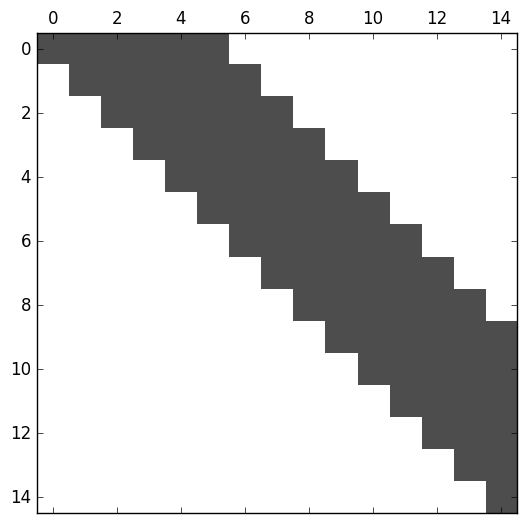

5x2 Array{Float64,2}:
 7.84257  7.84257
 6.83254  6.83254
 6.14353  6.14353
 5.82378  5.82378
 5.20788  5.20788

In [17]:
A=block(randn(15,15))
A_after=BandBidiagonal(A)
spy(A_after)
[svdvals(unblock(A))[1:5] svdvals(unblock(A_after))[1:5]]

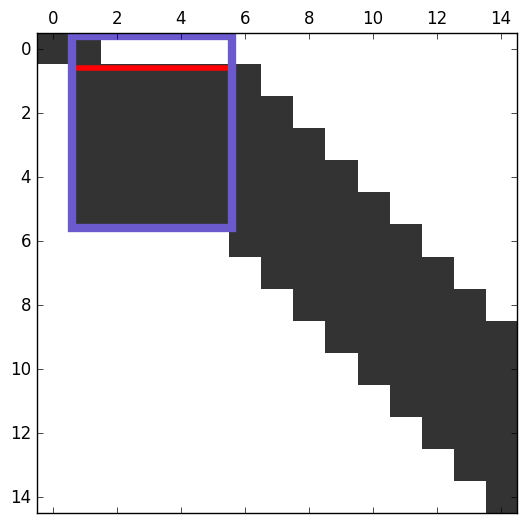

PyObject <matplotlib.patches.Rectangle object at 0x31b61f450>

In [8]:
A=unblock(A_after)
Q1=qrQ(A[1,2:6]')
A[1:6,2:6]*=Q1
spyt(A)
rect_red(1:1,2:6)  #QR from this block
rect_blue(1:6,2:6) #QR applied to this block

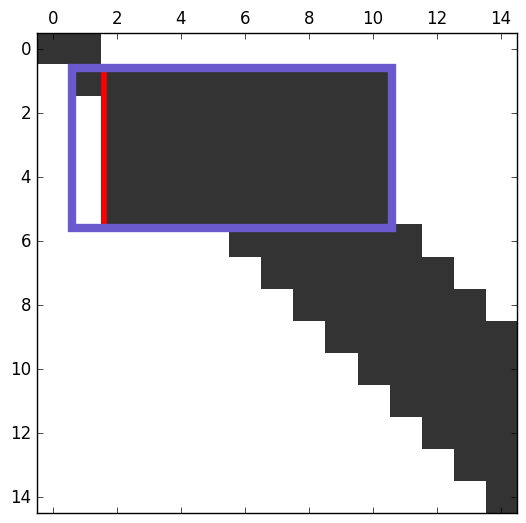

PyObject <matplotlib.patches.Rectangle object at 0x31b9d2610>

In [9]:
Q2=qrQ(A[2:6,2:2])
A[2:6,2:11]=Q2'*A[2:6,2:11]
spyt(A)
rect_red(2:6,2:2)  #QR from this block
rect_blue(2:6,2:11) #QR applied to this block

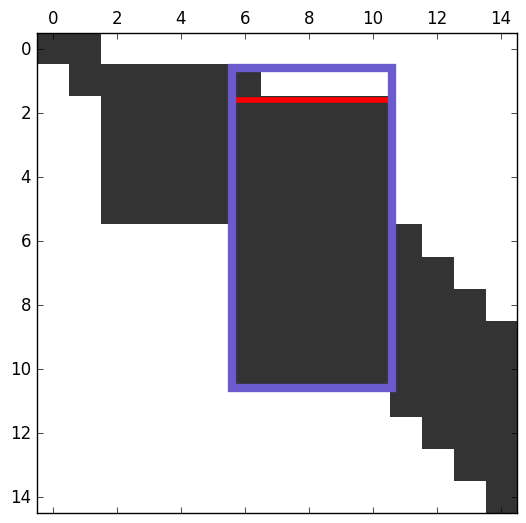

PyObject <matplotlib.patches.Rectangle object at 0x31b376790>

In [10]:
Q3=qrQ(A[2,7:11]')#Clear the fill-in from the previous block
A[2:11,7:11]*=Q3
spyt(A)
rect_red(2:2,7:11)  #QR from this block
rect_blue(2:11,7:11) #QR applied to this block

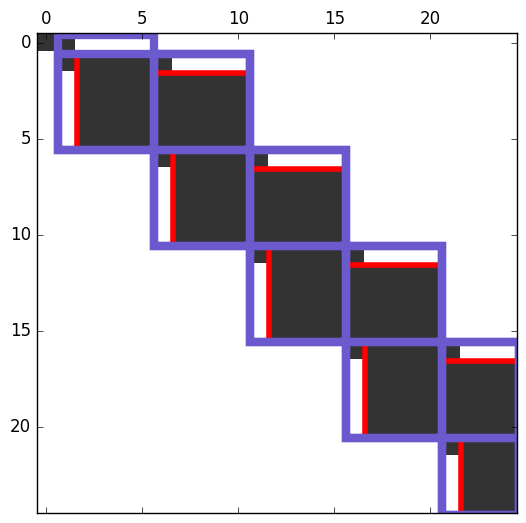

PyObject <matplotlib.image.AxesImage object at 0x31c1ebb90>

In [11]:
A=block(randn(25,25),5,5);
A=BandBidiagonal(A);
s=size(A[1,1],1) #Square block size
n=size(A,1)      #Number of blocks
A=unblock(A)
i=1
Q=qrQ(A[i,i+(1:s)]') #odd
A[i+(0:s),i+(1:s)]*=Q
rect_red(i:i,i+(1:s))  #QR from this block
rect_blue(i+(0:s),i+(1:s)) #QR applied to this block
for i=1:s:((n-2)*s)
    Q=qrQ(A[i+(1:s),i+1:i+1]) #even
    A[i+(1:s),i+(1:2s)]=Q*A[i+(1:s),i+(1:2s)]
    rect_red(i+(1:s),i+1:i+1)  #QR from this block
    rect_blue(i+(1:s),i+(1:2s)) #QR applied to this block
    Q=qrQ(A[i+1,i+s+(1:s)]')  #odd
    A[i+(1:2s),i+s+(1:s)]*=Q
    rect_red(i+1:i+1,i+s+(1:s))  #QR from this block
    rect_blue(i+(1:2s),i+s+(1:s)) #QR applied to this block
end
i=(n-2)*s+1
Q=qrQ(A[i+(1:s),i+1:i+1]) #even
A[i+(1:s),i+1:end]=Q*A[i+(1:s),i+1:end]
rect_red(i+(1:s),i+1:i+1)  #QR from this block
rect_blue(i+(1:s),i+1:(n*s)) #QR applied to this block
Q=qrQ(A[i+1,i+s+1:end]')  #odd
A[i+1:end,i+s+1:end]*=Q
rect_red(i+1:i+1,i+s+1:(n*s))  #QR from this block
rect_blue(i+1:(n*s),i+s+1:(n*s)) #QR applied to this block
i=(n-1)*s+1
Q=qrQ(A[i+1:end,i+1:i+1]) #even
A[i+1:end,i+1:end]=Q*A[i+1:end,i+1:end]
rect_red(i+1:(n*s),i+1:i+1)  #QR from this block
rect_blue(i+1:(n*s),i+1:(n*s)) #QR applied to this block
spyt(A)

In [12]:
function block_bidiagonalize(M,s1=5,s2=5; record_video=false, video_file="blocksvd.mp4")
    if record_video
        video = anim.FFMpegWriter(fps=6, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])
        video[:setup](plt.gcf(), video_file, dpi=100)
    end
    A=BandBidiagonal(block(M,s1,s2), record_video)
    s=size(A[1,1],1) #Square block size
    n=size(A,1)      #Number of blocks
    A=unblock(A)
    for j=1:n*s-2    #bulge chasing: elimination on row j+1
        ebb=min(j+s,n*s)
        Q=qrQ(A[j,j+1:ebb]')           #xGBCW1
        A[j:ebb,j+1:ebb]*=Q
        spyt(A)
        rect_red(j:j,j+1:ebb)  #QR from this block
        rect_blue(j:ebb,j+1:ebb) #QR applied to this block
        record_video && video[:grab_frame]()

        lastb = ((n-floor(div(j,s)) - 1) * s) + j #index of last block
        for i=j:s:lastb
            ebb, ebp1=min(i+s,n*s), min(i+2s,n*s) #index of end of block and its neighbor
            Q=qrQ(A[i+1:ebb,i+1:i+1])  #xGBCW2
            A[i+1:ebb,i+1:ebp1]=Q*A[i+1:ebb,i+1:ebp1]
            spyt(A)
            rect_red(i+1:ebb,i+1:i+1)  #QR from this block
            rect_blue(i+1:ebb,i+1:ebp1) #QR applied to this block
            record_video && video[:grab_frame]()
            i==lastb && break
            Q=qrQ(A[i+1,i+s+1:ebp1]') #xGBCW3
            A[i+1:ebp1,i+s+1:ebp1]*=Q
            spyt(A)
            rect_red(i+1:i+1,i+s+1:ebp1)  #QR from this block
            rect_blue(i+1:ebp1,i+s+1:ebp1) #QR applied to this block
            record_video && video[:grab_frame]()
        end
    
        #Gray out stuff
        plt.clf()
        endb=min(j+s,n*s)
        rect_gray(j:j,j+1:endb)
        rect_gray(j:endb,j+1:endb)
        for i=j:s:lastb
            endb, endbp1=min(i+s,n*s), min(i+2s,n*s)
            rect_gray(i+1:endb,i+1:i+1)
            rect_gray(i+1:endb,i+1:endbp1)
            rect_gray(i+1:i+1,i+s+1:endbp1)
            rect_gray(i+1:endbp1,i+s+1:endbp1)
        end
    end
    
    plt.clf()
    spyt(A)
    if record_video
        video[:grab_frame]()
        video[:finish]()
    end
    
    A
end

block_bidiagonalize (generic function with 3 methods)

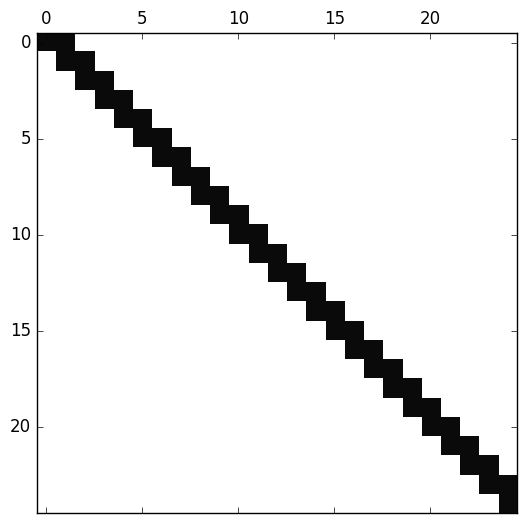

PyObject <matplotlib.image.AxesImage object at 0x326085710>

In [14]:
M=randn(25,25)
A=block_bidiagonalize(M,5,5, record_video=true)
spyt(A)

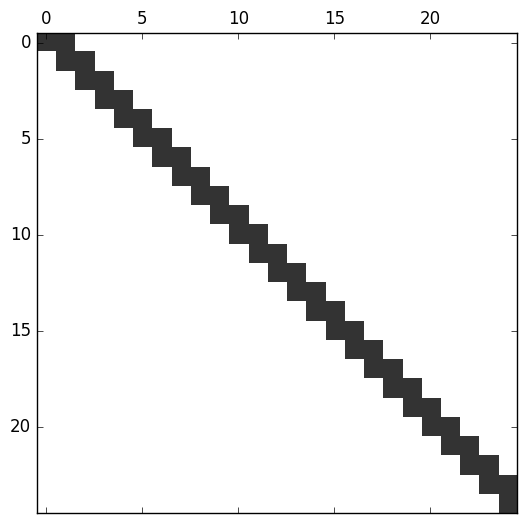

25-element Array{Float64,1}:
 9.04719 
 8.80247 
 8.24647 
 7.39028 
 6.80796 
 6.2762  
 6.10041 
 5.80281 
 5.28209 
 4.64855 
 4.4259  
 4.19782 
 3.73575 
 3.50093 
 3.13476 
 2.6626  
 2.4426  
 2.3225  
 1.59833 
 1.58409 
 1.50744 
 1.28274 
 1.04086 
 0.673196
 0.355857

In [16]:
function block_svdvals(M,s1=5,s2=5)
    A=block_bidiagonalize(M,s1,s2)
    B=Bidiagonal(diag(A), diag(A,1), true)
    svdvals(B)
end

block_svdvals(M) 
svdvals(M)

In [15]:
# ;ls -l *.mp4
embed_video(filename)=display("text/html", string("""<video autoplay controls><source src="data:video/x-m4v;base64,""",
                            base64encode(open(readbytes,filename)),"""" type="video/mp4"></video>"""))
embed_video("blocksvd.mp4")
embed_video("band_bidiagonal.mp4")

<source src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQACXldtZGF0AAACrgYF//+q3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE0OCByMjYwMSBhMGNkN2QzIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAxNSAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEyIGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj02IHNjZW5lY3V0PTQwIGludHJhX3JlZnJlc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAgcXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAOx2WIhAAR//73iB8yy2n5OtdyEeetLq0fUO5GcV6kvf4gAAADAAADAAADADo2G98f8mU66joAAAMAB7Hi38Rj/DiBjgumtnx6gK1lsN5ZMPCZ2glO4sW+Qm7pvxyuWbJqigq2nnhTVJCqnP0gUbGXWaoMMt0MJvcT9VrIm/GyGzOiBAwOV40x2Jq8+aLoCDpbOU9k3PfqjKJgvr/2SCUjEqnNir/SGHeUx7COUHFFqlwwalcywGuEviXd5CetsF7tSIWH0Tx3agcNQnU9oaV3JTuSOzWkQBtBYVgePIGqyDsLmnoMUOFPUFaI1H0Ptyo0qh7kqOxauPi5T5HCfG++KiKbiuB827kDGovQuHpPgo21/hmJ3afREwVLElXVEPdRs/mEWLF4lhngo20NXcz0zOXpC98lDUdBZ/x7rlmhbuoAHH7LUpfdDDC29YeD84xJyGzBBpi7UupwthOmlYfv+pOVsdP/jjomzHbjr+eiS92TtyOn1PKOCUzQrJpkO9ah/IF5slK+2/2Z797lm+epJ0CAFnWVt35WabyPKWUElI55edml8wcP43bTr8aFWtjlBgHJcCfKmnLF/rqatfS9xWE1TjCaFqX7QKk3sJ/rdnHd478XxN1r7ehRD42w3CUxo2hh3wjMTb3rRGnnDPtN+9gfLRj8L9Xb3O6vLNMgAJb0OjGX85Sk6QK0/FKdZwxJnZXsUgHKM5cDzuqnyFUY0n3141Zz5nFqi6A9Cz0cAGJLLalDamU+I/GPU/JY0qHvG3fFGLkeJJEk1Gdwl/WiumGVnCnQJomOLi0u1+XgJD1jIEabd1PKq6zc176OFjzf/grbB/aT9x9bl0YYYXjDlbH1gptJ4ciKL6GWgl9wIGOnfTPJBHzWGiL4bykNJgDaMhmwmExwRresQ8RYhmqKTr2PCzYl8nEgbMeSDTZrAWhk46N1jvMcw3L//81PRhoJ7uOlNHxMhgwNcZdsFV71QFKW094ywdz9EtNk27FWr0B+9FALg1uwIaIDzna5sAQhba1aF94qa/inbCFp3Ci6MdKfgnvEsMDe7TkLFDLVkoIFIg3kMvxsSeLEmtaIpj4BwmUr/Qidz0ITLA+clj5//JKyrp9HC1zTYaNYE3MVza72iLCP51OdCAp0ypLUktAiEWt/0VCSVsObCgLK6gViyo3DQiSspi+MyEcO2sMtEPsnUf14RhEA8RKQA2e1cvS/+uP7wQ7cRu10GWZ9bktWga1kCtb1Ycnbju2uDHqB2x7Q2lIsQNjLXjCcbo//k2aWeA7Zw/SWM8JrLEwLxFCfO4UUAO8oAksrAVZPhrXTyvpIXEg5d0GRMvYo2XCRajPHgOKUc0NJ2SYQZdPjRRosEe62Djz9KDvKQF5QFaeSrlydB7R+0ldXbIh6dtqctcy6V+u0vF/snGYXN0cl2mDiFH7wcNt1d111K/O5363eUqb4/vauVMXJks3DznczCaZhhEA0Ydkv0txs3Rme7HeRd7Z8qWb2muYI/TgogTcerFbfLbu26fsOFipJZC4Bc7lRtl2mWhhuZa9AR1piigTsXpxUXEdDY01+gW/nyKJhYgYq+3hDymaY/FTWf/dk/mxJUYOxsacUAf+71K5bW2qP//8tCrVqwB5X0D4ZqucB3i/QQVMCag7JvtxtlxJ3uoBXHnG1qLT1sAm0GXrevDYMtZfgdDWmkV07RmNmiOxcef+GAdxlc3v927508oLFwtU/9+hHjGcrROyWz/jU8kfNcQ8J3hgJgZMkh/YqLvDZhRV/jmxvXr/Rl9O+2rjdL5ibSnVpKhMOa+gweCHrIMkzhjaod2r1jmFYOEG025wr2aEMM06SUp1wlU0cdKrqOukslYSQWcLeZY+z6H+8u1VDOtfiSZDlGDw2ZQVx4QKwbExf+Jm8GsPvu+oq8A/3WS9Xx9VQlE1KLCbrCVnozFV7bAMGUEbb2tmZarO3h1KnqxqVPJI2jBhTLiuoMdJBL2pkt1iaqzTw6QKGDUToIhcEu5lZLvjwFCJwjzj09uIJN1rXqSd9enbul17lRrd7Wjs53N8rLXnDp6WrnuUGaMpCxzF6SKN91C+oWodU1QIHJCotAXpjNu3JuSCpNR5t7+dDulDgzl7vQ6S8s6Tlr333e/J43uBXbkF0pGml/jGZt+8ndv7It57fcohoe21SCaPlUTKRxfBHf0I2dFm3ivgYl3i9fe2PyTQAAHOmyL7SEAaljyrSgYI0bTgfutzqroOrTaQHqVSGHHGP/7cBfWMSx9YB/RooS1nMIJEf0GqU3s1/WWDwBecH5lfapN+HTJpF1Ym9cku28YAJZs6sk6LS5MquMDQGjlx+S+ETFG3liSsXmGZGQKFFJyv2jKVvT7n9vze/jhcep6cyOroBa2ZHvhZEm6wM2o78rvNDNcoU+ZQDMiu0oqoSACZ3sBZghXf54/WEQgQggMPDBj93DDnTDr144XG3QVpuOq0WRrbRChKvy8f9cVuqIJqJakMBZ6O2zLrIGxx2j3W/kZgbm1f6MYKl9X5jHj7Rwym1MnyLuS35xXvXd8if4xzg9IIJuziIIHQd/0bJmn6GqdOk96X2wFn8Z+M8y99eX576LbrZ8UZaUgLZxl3EB1QZTlJ9hP5H24kFzk2+yKtdnUhX77ottLGYSm3X7wnoqxUwnxwVKgpSSmEat7IVuXJMJioRjuwPXsYCTKYsHqPbuWpTasp8YbgBrC2FfYJ40c2dyALrQePyEROFkxJFN+BBEqgwhXB9fgKUSW4k4J/89+O6Lfij8D3oqZ/ZxMNmStdXOCbWJ7nYiafIrYSvnFtoUQX11kieQu4w0QfDPoy7arU5rhRmDN4/FCRClJ+xQlWLGoEw+x3Yeda2mNH8hePPaUyCZu8UpThEXs21bnnWRGag/ddaw7HwBZ59y2bZ8BOYWvBepbix55mntVa5PEF7p0r9A9ELRh4cBvkcpct1WuQWlWqfgw2Xr8A0wgv

<source src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAR8xtZGF0AAACrgYF//+q3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE0OCByMjYwMSBhMGNkN2QzIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAxNSAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEyIGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xIHNjZW5lY3V0PTQwIGludHJhX3JlZnJlc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAgcXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAANrGWIhAAW//730z/Msuv3ObXjqPeiniZfQ3UlAZuWxO06gAAAAwAAAwAAAwAP4TBbUuEVCYwWgAAAAwHgq3f+QvDrwAxLVWT4pB1jeHwqNQsm4xy6eFBeHLCoJ0PhxVU94s8yr/O10NqmuWy854U1SR4fRRpsB88vsSEytWNsXnaG6dg8+mUGaPkrdEu+fTnhPZT7l3+nWxEIIeFaciCJjwO7hUvSrgWMkO6gVIruYldV/FPEJ4CUcE7Y9FgLn/pFPtjB3iHCSWlwdl+oRhZQFrxBqpY7Kw3Kitw6UPaboM4qAE0dg2Boy8BO6+/UO7DjsHDUzJBxBq/eMtwwMKXqM9PTH2GIMvISE8XrxYoSIOP8RJ9fniJwcesTBFa4DiHspnyDGQlbMkboI8D7G9siIDMME/1j5OY8PGj5lUJ7Ed6w0p3EACd/wCc/JqldkUSHE5t13+Ngvugk1tHQSp1lk/DUn5cxEI6+HVMIhWA+eio2pA6XZisibQlx4QfQPCQ37rj8H/bjaWQV2pneLOyjMgsgauJzSzvdYj2c1V3rtan5id/S6OEyH8iJ3KXzVdzRwhhYimjLutpAUy5W7mtq2tF6T/jXg+kzZ3Ikn5URR7G1u10WdA89uoK2NQt7P+laetTU8T8N7yZX87VSZajlsAA/t/RI3pKtzweNO5rjkfU/50U35AUm7pqGcggwwSPiclrqQ4ugcYO6rKQQyJKNFhhUIOJShxNTmp1Pwfp/zoFORElXsogU+WVTWt+pVmuzOayjVTFHMTHwfPJd7kiasrvnl+tio7IfXSCXnaDjVMtvtaXi2yywst3Uz+FzWjhLlnQo/ly8rGMWT1vNM6Su+hIdQa2W63whXEoph/WQp6Ycn6rbuimeZvw1vEtVKpqcJ+gRnVaXuK+1lN9gLbuZsZFu8cmvO+fmGhSzEgLIrgQtHH40Iu+EOYqpgWpSDtd73JpHqdQ8r/EONy5+JWfemH4qWNwZLHkNc/j/zmK01Lv+rSGVdVUhPX/xaSLKCIGGk7G6yohSYcvH9gJ39qoeIx+MiWP0XMSOgpW/1qbQ37kkL5/FuCbQ8QIJXPsdcE4oAEeX8Ic6/qWQgB+7JbN76XaAVKGFdLXb4hwMUzyfoXBIJxvnP7iPpTETM2JmEcb/ezk3wRTYvGCRmfqNyIB7G23DUZ/Gm69nG+beOrvBoY8XvinrwVf//pvtp8YGFWLKn2ZnM6rcvCWWwW6q2meTfFpLweaawmIh/AUW2krM6p+XFMS8n1wSR9kCTDvqljM1vFlUlMxkaYhiLctFI3VKS7rfWeT9dOzdECyDGbPTaX2BykefklAntIrn+BsU8HT6eKzjEgefw+/2+Wsb1s9eCAbyzcWXkvNEyoianKxt4coZyRbj3AVzhLShN/qSuODIkesiuU5S4Max1Z9OvyOBcCJdcz/Asjd/ZV1MS/+Dj+2G8r9GEWzwANLm1r7icZsDmmdJrdn4OeESit2y5nJjQq82HnyhHJyyx4is8J91kYe/aiMFzv7OflWbiEJbE6yemE4/4ezfJOOjbuJ1CKeskAAD8dHS0NmWaovW4fxeHeleQjWkSlRQ2kh4R1BH8JlOIE1S8JV7BxAr3Q9GXP8nnfX1JYVK3l1ZIU1IcD5QOJoRhuD4dvmZ6oOCPGAGubBeYGnWbaUijQoevkLk7bEWlwVF0GKGX/yMGCV6WVRBQOTL5zmDo4rh7j+AiEqlbf9aHDUHoiX0onrTW0hWyBkc/jXmXdLQTmUtGFkjGM6mAep3SEc/dw1Wcy6tlFHHJskkV399W6rULSAq3k+dr1s+aFscv+hucepTkcOMYOZteWAHgp7WLuH5vrNWIOc1PljkZdDIYR08rsHvArrhVogh///ecoe6Q/kSuS37VCsAQRZIOJkgOrQmXucTTmkTiSrmuHM190RToq4ee6Z3dkJ9p+8D1Jt1cb/eQf6xMUfGZrZ8wToSdBegdTAzg4k/wm7ab2q1ub0DQsJBgp8kylO8AKkgYv898U5pAG6Y0pHDLZswSAeevwRsIBNdyDocTYPWYbYxXoaX5OIJX8JLQbZtgHogyGkwRRma88OjF6GjgD6YAz6PeKh3pu1COvXZAtBa4w6VbIt5nEtQJNaV5fxQhUWMt/5+GPiDkpGE7ILWuo/IjMrv4f/4W3PvjufToWhnn6y1oemA23iJnQIEZ3w7oBOE7efCZL7gb5gckgBobJM+brvuCBVxSM69BopsLz2BImfji7Ae/IROINOGEK0X3iklmcKyIDjFj/mBXd7wDF8eEnXT+GglB2M0yh31N6u/LD8d4FyFEYHSIQfgQFIVd+cOpYVFdIzwg47Np/PBBg6xtAvsaeP4JhNXyrUiSb++OXimDjvu9b7e07q/wmpmY/44P+JBjXNdiA0sr2gqpg5ciMBUb+iWQZ0vqGUfbegVyOS+ghpV77P/zM7qJVOxEg51/RkP53bDZ8YzOoCl/x/bONjwwx1c0pwdA4zCiRv15ZR7q1r+0LEi/z4OAabREiQHlBjyxFjyNJQFSpvylvXmcnKHqN/7lg0UjfPmABOw2X/Xhca99nxb3AsS6S/y8tQgPfEG8BGOFce0eVTVIARJXiT7gubCDJnOfIeD8o1X1HARMTUHjAAzB/x+6/iL1kRVos/dW6MxA4k7WNtc6cr7Wj0efr93kpY5bn2EJoYpcrb+K50yJ1IkL9GnrcW+htVHv185j2yROvXFwQJHHlML09Bo7BIvP6vuRxECzap+IFOGzhPByPhzYd4q/sRrvnsJGAg177KOf8zmKWCBia4bT1Uz+1cMuoVDKOTcP/dZTyTFNaEEGWtpZ9oCAm5L6B69UhZJPHrXvRwsQMj/n1QAXmrBw4iY7Kbl6eRvA8aQlTJCFoI9FUmT+xFjzNeyZjVembI/jbapao0QPcpPdghqvXfuk0nRtbB8ZINcMuZY8A/++Isn6j0vFR+s6XPmjALe+B4i4mR